# Comparing the Dynamics of Regular and Mass-Conserved FitzHugh–Nagumo Systems

**Motivation:**  
The FitzHugh–Nagumo (FHN) model is widely used for excitable dynamics with applications in biology and chemistry. Recently, active matter studies have highlighted the role of non-reciprocal energy injection and mass conservation. In this notebook we:
 
1. **Formulate the Models:** Define the regular FHN system and a mass‑conserved version.
2. **Local Dynamics Analysis:** Perform a linear stability analysis of the homogeneous steady states for both systems to reveal differences in stability and bifurcation behavior.
3. **Spatial Pattern Formation:** Use finite‑difference simulations to explore wave propagation, pattern formation, and the influence of the conservation law.
 
---
 
**Main Equations:**
 
**Regular FHN System:**
   $$
   \begin{aligned}
      \frac{\partial u}{\partial t} &= f(u,v) + D_u \nabla^2 u,\\[1mm]
      \frac{\partial v}{\partial t} &= \epsilon\, g(u,v) + D_v \nabla^2 v,
   \end{aligned}
   $$ 
   with
   $$ 
   
     f(u,v) = u-\frac{u^3}{3} - v,\quad 
     g(u,v)= u + a - b\,v.
   $$
 
**Mass-Conserved FHN System:**
   $$
   \begin{aligned}
      \frac{\partial u}{\partial t} &= -\nabla^2\Bigl[f(u,v) + D_u \nabla^2 \Bigr],\\[1mm]
      \frac{\partial v}{\partial t} &= -\nabla^2\Bigl[\epsilon\, g(u,v) + D_v \nabla^2 v\Bigr].
   \end{aligned}
   $$

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
from scipy.stats import linregress

## 2. Local Dynamics Analysis: Homogeneous Steady States and Linear Stability

For homogeneous (spatially constant) solutions the diffusion terms vanish. The fixed point (FP)
must satisfy:

\begin{aligned}
f(u, v) &= u-\frac{u^3}{3} - v = 0,\\[1mm]
g(u, v) &= u + a - b\,v = 0.
\end{aligned}

Eliminating $v$ (i.e. $v = u - \frac{u^3}{3}$) $$ in the second equation leads to the cubic:
$$
\frac{b}{3}u^3 + (1 - b) u + a = 0.
$$
We use `np.roots` to solve this cubic and then compute the corresponding \(v\) values.
 
The Jacobian for the regular FHN (reaction part) is:

$$
J = \begin{pmatrix}
1-u^2 & -1\\[1mm]
\epsilon & -\epsilon\,b
\end{pmatrix}.
$$

The eigenvalues of \(J\) determine the local stability of the FP. For the mass‑conserved system, the
homogeneous FP are the same (the diffusion terms vanish), but spatial perturbations with nonzero wavenumbers alter the stability.

In [11]:
# Reaction functions
def f(u, v):
    return u - u**3/3 - v

def g(u, v, a, b):
    return u + a - b*v

# Helper functions
def steady_state_fp(a, b):
    coeffs = [b/3, 0, (1-b), a]
    roots = np.roots(coeffs)
    u_fp = np.real(roots[np.isclose(np.imag(roots), 0)])
    v_fp = u_fp - (u_fp**3)/3
    return u_fp, v_fp

def jacobian(u_fp, epsilon, b):
    return np.array([[1 - u_fp**2, -1], [epsilon, -epsilon*b]])

def analyze_fp(a, b, epsilon):
    u_vals, v_vals = steady_state_fp(a, b)
    print('Fixed Points (u, v):')
    for u_fp, v_fp in zip(u_vals, v_vals):
        print(f'u = {u_fp:.4f}, v = {v_fp:.4f}')
        J = jacobian(u_fp, epsilon, b)
        eigs = np.linalg.eigvals(J)
        print('Eigenvalues:', eigs, '\n')

def dispersion_relation(a, b, epsilon, Du, Dv, ks):
    u0 = steady_state_fp(a, b)[0][0]
    reg = [max(LA.eigvals([[1-u0**2-Du*k**2, -1],[epsilon, -epsilon*b-Dv*k**2]]).real) for k in ks]
    mc  = [max(LA.eigvals([[k**2*(1-u0**2)-Du*k**4, -k**2],[epsilon*k**2, -epsilon*b*k**2-Dv*k**4]]).real) for k in ks]
    return np.array(reg), np.array(mc)

In [12]:
# Parameters
a = 0.1
b = 2
epsilon = 0.01
Du = 1.0
Dv = 2.0
n_space = 100

domain = (0, 200)

#dx = 1.0
dx = (domain[1] - domain[0]) / n_space 
dt_max = dx**4 / (8 * Du)
dt = min(0.01, dt_max * 0.5)

In [13]:
# Analysis of the fixed point
analyze_fp(a, b, epsilon) 

Fixed Points (u, v):
u = -1.2720, v = -0.5860
Eigenvalues: [-0.60070621 -0.03722041] 

u = 1.1713, v = 0.6356
Eigenvalues: [-0.34076098 -0.05117586] 

u = 0.1007, v = 0.1003
Eigenvalues: [ 0.97986208 -0.00999862] 



## 3. Spatial Pattern Formation: Simulations
 
We now simulate the spatially-extended versions of the systems by discretizing space (using finite differences) and time (using a forward-Euler scheme).
 
The following functions implement:
 
**Regular FHN:**
$$
   \begin{aligned}
   \partial_t u &= f(u,v) + D_u \nabla^2u,\\[1mm]
   \partial_t v &= \epsilon\,g(u,v) + D_v \nabla^2v,
   \end{aligned}
$$

 
**Mass-Conserved FHN:**
$$
   \begin{aligned}
   \partial_t u &= -\nabla^2\Bigl[f(u,v)+D_u \nabla^2u\Bigr],\\[1mm]
   \partial_t v &= -\nabla^2\Bigl[\epsilon\,g(u,v)+D_v \nabla^2v\Bigr].
   \end{aligned}
$$
 
You can choose which system to simulate by uncommenting the corresponding block.


In [14]:
# Build neighbor indices for lattice Laplacian
def build_neighbors(n, bc='periodic'):
    N = n*n
    inds = np.arange(N).reshape(n, n)
    nbrs = []
    for di, dj in [(-1,0),(1,0),(0,-1),(0,1)]:
        if bc=='periodic':
            nbr = np.roll(np.roll(inds, di, axis=0), dj, axis=1).ravel()
        else:
            nbr = []
            for i in range(n):
                for j in range(n):
                    ni, nj = i+di, j+dj
                    nbr.append(inds[ni, nj] if 0<=ni<n and 0<=nj<n else N)
            nbr = np.array(nbr)
        nbrs.append(nbr)
    return np.vstack(nbrs), 4

# Simulation: regular FHN with selective saving
def simulate_regular_fhn(T, dt, n_space, domain, a, b, epsilon, Du, Dv, 
                         save_every=1, bc='periodic'):
    x0, x1 = domain
    dx = (x1-x0)/n_space
    t_vec_full = np.arange(0, T+dt, dt)
    nbrs, mult = build_neighbors(n_space, bc)
    u = 0.1 + 0.01*np.random.randn(n_space, n_space)
    v = 0.1 + 0.01*np.random.randn(n_space, n_space)
    u_list, v_list = [], []
    for idx, _ in enumerate(t_vec_full[1:], start=1):
        uf, vf = u.ravel(), v.ravel()
        u_ext = np.concatenate([uf, [0.]])
        v_ext = np.concatenate([vf, [0.]])
        Lu = (u_ext[nbrs].sum(axis=0) - mult*uf)/(dx**2)
        Lv = (v_ext[nbrs].sum(axis=0) - mult*vf)/(dx**2)
        Lu, Lv = Lu.reshape(n_space,n_space), Lv.reshape(n_space,n_space)
        u = u + dt*(f(u, v) + Du*Lu)
        v = v + dt*(epsilon*g(u, v, a, b) + Dv*Lv)
        if idx % save_every == 0:
            u_list.append(u.copy())
            v_list.append(v.copy())
    t_sampled = t_vec_full[save_every::save_every]
    X = Y = np.linspace(x0, x1, n_space)
    return np.meshgrid(X, Y) + [t_sampled, np.array(u_list), np.array(v_list)]

# Simulation: mass-conserved FHN with selective saving
def simulate_mass_conserved_fhn(T, dt, n_space, domain, a, b, epsilon, Du, Dv, 
                                save_every=1, bc='periodic'):
    x0, x1 = domain
    dx = (x1-x0)/n_space
    t_vec_full = np.arange(0, T+dt, dt)
    nbrs, mult = build_neighbors(n_space, bc)
    u = 0.1 + 0.01*np.random.randn(n_space, n_space)
    v = 0.1 + 0.01*np.random.randn(n_space, n_space)
    u_list, v_list = [], []
    for idx, _ in enumerate(t_vec_full[1:], start=1):
        uf, vf = u.ravel(), v.ravel()
        u_ext = np.concatenate([uf, [0.]])
        v_ext = np.concatenate([vf, [0.]])
        Lu = (u_ext[nbrs].sum(axis=0) - mult*uf)/(dx**2)
        Lv = (v_ext[nbrs].sum(axis=0) - mult*vf)/(dx**2)
        inner_u = f(u, v) + Du*Lu.reshape(n_space,n_space)
        inner_v = epsilon*g(u, v, a, b) + Dv*Lv.reshape(n_space,n_space)
        iu, iv = inner_u.ravel(), inner_v.ravel()
        iu_ext, iv_ext = np.concatenate([iu, [0.]]), np.concatenate([iv, [0.]])
        L2u = (iu_ext[nbrs].sum(axis=0) - mult*iu)/(dx**2)
        L2v = (iv_ext[nbrs].sum(axis=0) - mult*iv)/(dx**2)
        u = u - dt*L2u.reshape(n_space,n_space)
        v = v - dt*L2v.reshape(n_space,n_space)
        if idx % save_every == 0:
            u_list.append(u.copy())
            v_list.append(v.copy())
    t_sampled = t_vec_full[save_every::save_every]
    X = Y = np.linspace(x0, x1, n_space)
    return np.meshgrid(X, Y) + [t_sampled, np.array(u_list), np.array(v_list)]

## 4. Visualization

We now compare snapshots of the fields (activator u and inhibitor v) and animate the evolution of u for both models.

In [15]:
# Plotting helper
def plot_field(ax, X, Y, field, title='u'):
    pcm = ax.pcolormesh(X, Y, field, shading='auto', cmap='inferno')
    ax.set_aspect('equal')
    ax.set_title(title)
    plt.colorbar(pcm, ax=ax)

In [16]:
print(f"Using dt = {dt:.5f} (<= stability limit {dt_max:.5f})")

# Choose how often to save frames (to limit memory)
# e.g., save_every = 50 means store 1 frame every 50 steps
save_every = 50
print(f"Saving every {save_every} steps.")

Using dt = 0.01000 (<= stability limit 2.00000)
Saving every 50 steps.


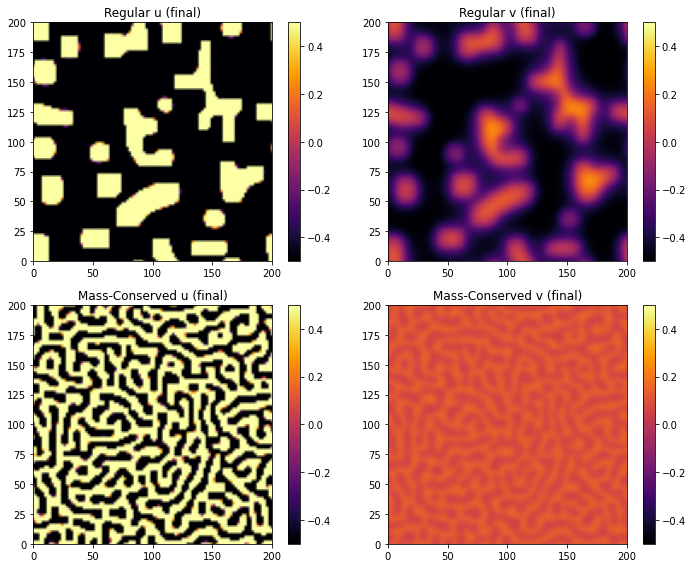

In [17]:
# Analysis & plotting
# Parameters
T, a, b, epsilon = 100, 0.1, 2.0, 0.01

# Simulations
Xr, Yr, tr, ur, vr = simulate_regular_fhn(
    T, dt, n_space, domain, a, b, epsilon, Du, Dv, 
    save_every=save_every
)
Xm, Ym, tm, um, vm = simulate_mass_conserved_fhn(
    T, dt, n_space, domain, a, b, epsilon, Du, Dv, 
    save_every=save_every
)


# 2. plotting with shared vmin/vmax
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for ax, data, title in [
    (axes[0,0], ur[-1], 'Regular u (final)'),
    (axes[0,1], vr[-1], 'Regular v (final)'),
    (axes[1,0], um[-1], 'Mass-Conserved u (final)'),
    (axes[1,1], vm[-1], 'Mass-Conserved v (final)')
]:
    pcm = ax.pcolormesh(Xr, Yr, data, shading='gouraud', cmap='inferno', vmin=-0.5, vmax=0.5)    
    ax.set_title(title)
    ax.set_aspect('equal')
    plt.colorbar(pcm, ax=ax)

plt.tight_layout()
plt.show()

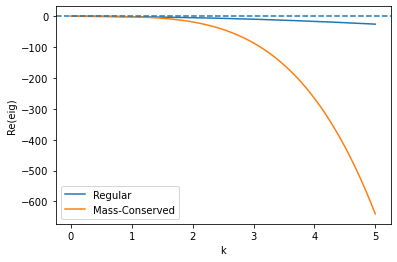

In [20]:
# Dispersion plot
ks = np.linspace(0,5,300)
disp_reg, disp_mc = dispersion_relation(a, b, epsilon, Du, Dv, ks)
plt.plot(ks, disp_reg, label='Regular')
plt.plot(ks, disp_mc, label='Mass-Conserved')
plt.axhline(0, linestyle='--')
plt.xlabel('k'); plt.ylabel('Re(eig)')
plt.legend(); plt.show()

## 5. Robustness Analysis to Noise and Parameter Perturbations
 
Next, we add stochastic noise to the update equations (using an Euler–Maruyama scheme) and compare the final snapshots of the activator u for both models. We run simulations with
different noise amplitudes to see how robust the spatial patterns are.


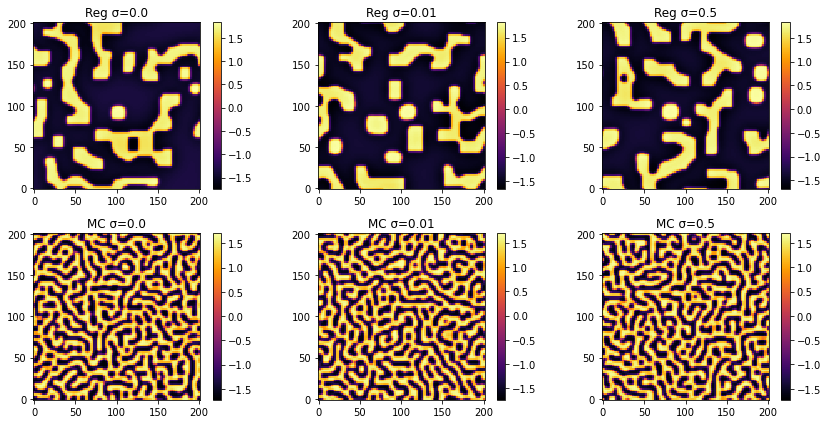

In [21]:
# Noise study
noise_levels = [0.0, 0.01, 0.5]
final_r, final_m = [], []
for sigma in noise_levels:
    _, _, _, ur_n, _ = simulate_regular_fhn(T, dt, n_space, domain, a, b, epsilon, Du, Dv)
    _, _, _, um_n, _ = simulate_mass_conserved_fhn(T, dt, n_space, domain, a, b, epsilon, Du, Dv)
    final_r.append(ur_n[-1]); final_m.append(um_n[-1])

fig, axes = plt.subplots(2, len(noise_levels), figsize=(12,6))
for i, sigma in enumerate(noise_levels):
    plot_field(axes[0,i], Xr, Yr, final_r[i], f'Reg σ={sigma}')
    plot_field(axes[1,i], Xm, Ym, final_m[i], f'MC σ={sigma}')
plt.tight_layout()
plt.show()

## Extra Plots

In [ ]:
def measure_front_speed(u_time_series, x, t, threshold=0.5):
    """
    Measure front speed along a 1D slice (e.g., middle row) of u.
    u_time_series: array shape (nt, nx)
    x: spatial grid array of length nx
    t: time points array of length nt
    threshold: u value defining the front
    Returns: speed, positions, (intercept, r_value)
    """
    positions = []
    for ui in u_time_series:
        inds = np.where((ui[:-1] < threshold) & (ui[1:] >= threshold))[0]
        if len(inds) == 0:
            positions.append(np.nan)
            continue
        i = inds[0]
        x0, x1 = x[i], x[i+1]
        u0, u1 = ui[i], ui[i+1]
        alpha = (threshold - u0) / (u1 - u0)
        positions.append(x0 + alpha * (x1 - x0))
    positions = np.array(positions)
    valid = ~np.isnan(positions)
    slope, intercept, r_value, p_value, std_err = linregress(t[valid], positions[valid])
    return slope, positions, (intercept, r_value)


def plot_wave_profiles(u_time_series, x, t, times_to_plot=None):
    """
    Plot normalized wave profiles at selected times.
    """
    if times_to_plot is None:
        times_to_plot = [0, len(t)//2, -1]
    plt.figure()
    for ti in times_to_plot:
        if isinstance(ti, (int, np.integer)):
            idx = ti
        else:
            idx = np.argmin(np.abs(t - ti))
        ui = u_time_series[idx]
        ui_norm = (ui - ui.min()) / (ui.max() - ui.min())
        plt.plot(x, ui_norm, label=f"t={t[idx]:.2f}")
    plt.xlabel('x')
    plt.ylabel('Normalized u')
    plt.legend(); plt.show()


def extract_critical_mode(k, growth_rates):
    """
    From dispersion data, compute critical and most unstable modes.
    Returns dict with k_c, lambda_c, k_max, lambda_max, wavelength
    """
    idx_max = np.argmax(growth_rates)
    k_max = k[idx_max]; lambda_max = growth_rates[idx_max]
    positive = growth_rates > 0
    if positive.any():
        idx_c = np.where(positive)[0][0]
        k_c = k[idx_c]; lambda_c = growth_rates[idx_c]
    else:
        k_c = np.nan; lambda_c = np.nan
    wavelength = 2 * np.pi / k_max if k_max != 0 else np.nan
    return dict(k_c=k_c, lambda_c=lambda_c,
                k_max=k_max, lambda_max=lambda_max,
                wavelength=wavelength)

Wave speeds → regular: -0.309 (R²=0.086), 
mass-conserved: -0.108 (R²=0.048)


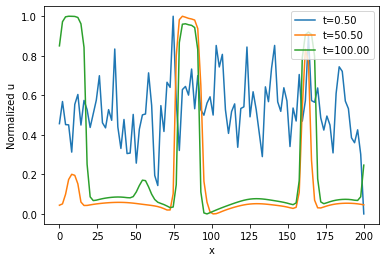

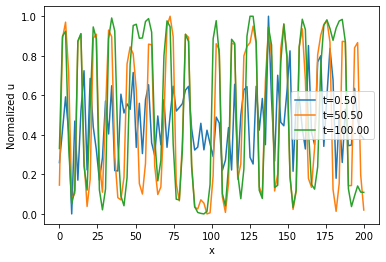

In [ ]:
# Wave speed & shape
# extract middle row
mid = n_space//2
u_series_reg = ur[:, mid, :]
u_series_mc  = um[:, mid, :]
x = np.linspace(domain[0], domain[1], n_space)

speed_reg, pos_reg, fit_reg = measure_front_speed(u_series_reg, x, tr)
speed_mc,  pos_mc,  fit_mc  = measure_front_speed(u_series_mc, x, tm)
print(f"Wave speeds → regular: {speed_reg:.3f} (R²={fit_reg[1]**2:.3f}), ")
print(f"mass-conserved: {speed_mc:.3f} (R²={fit_mc[1]**2:.3f})")

plot_wave_profiles(u_series_reg, x, tr)
plot_wave_profiles(u_series_mc, x, tm)
